#### Environment

 * [Visual Studio Code IDE](https://code.visualstudio.com/?wt.mc_id=DX_841432)
   * [Jupyter Extension for Visual Studio Code](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter)
   * [Python v3.9.13](https://www.python.org/downloads/release/python-3913/)

#### Imports

 * [Pandas](https://pandas.pydata.org/)
 * [NumPy](https://numpy.org/)
 * [missingno](https://github.com/ResidentMario/missingno)
 * [matplotlib](https://matplotlib.org/stable/index.html)
 * [sys](https://docs.python.org/3/library/sys.html)
 * [Seaborn](https://seaborn.pydata.org/)

In [16]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import sys
import seaborn as sb
from sklearn.decomposition import PCA

#### Load data & Consistant Clean-up

File: medical_raw_data.csv
<br><br>
Description:
    
* 1. Column is an unamed numbered column. We will be skipping this.
* 2. Datetypes will be converted to appropriate values

In [17]:
print(f"Current Python Version: {sys.version}")

file = './medical_raw_data.csv'

use_columns = range(1, 53)  # Skip first column
medical_data = pd.read_csv(file, header = 0, usecols = use_columns)

convert_to_category = {
    'Zip': 'category',
    'City': 'category',
    'State': 'category',
    'County': 'category',
    'Area': 'category',
    'Timezone': 'category',
    'Job': 'category',
    'Education': 'category',
    'Employment': 'category',
    'Marital': 'category',
    'Gender': 'category',
    'ReAdmis': 'category',
    'Soft_drink': 'category',
    'Initial_admin': 'category',
    'HighBlood': 'category',
    'Stroke': 'category',
    'Complication_risk': 'category',
    'Arthritis': 'category',
    'Diabetes': 'category',
    'Hyperlipidemia': 'category',
    'BackPain': 'category',
    'Allergic_rhinitis': 'category',
    'Reflux_esophagitis': 'category',
    'Asthma': 'category',
    'Services': 'category',
    'Item1': 'category',
    'Item2': 'category',
    'Item3': 'category',
    'Item4': 'category',
    'Item5': 'category',
    'Item6': 'category',
    'Item7': 'category',
    'Item8': 'category'
}

#update datatype listed in convert_to_category to category datatype
medical_data = medical_data.astype(convert_to_category)

#these are categorical variables(column) that need to be converted into Yes/No later for data uniformity
convert_to_category.update({'Overweight': 'category', 'Anxiety': 'category', })


Current Python Version: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]


#### Observe the Data Frames Information

In [18]:
medical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   CaseOrder           10000 non-null  int64   
 1   Customer_id         10000 non-null  object  
 2   Interaction         10000 non-null  object  
 3   UID                 10000 non-null  object  
 4   City                10000 non-null  category
 5   State               10000 non-null  category
 6   County              10000 non-null  category
 7   Zip                 10000 non-null  category
 8   Lat                 10000 non-null  float64 
 9   Lng                 10000 non-null  float64 
 10  Population          10000 non-null  int64   
 11  Area                10000 non-null  category
 12  Timezone            10000 non-null  category
 13  Job                 10000 non-null  category
 14  Children            7412 non-null   float64 
 15  Age                 7586 non-null   f

#### Detecting Duplicates

###### Duplicate detection methods
* Detecting duplicates as a row across all columns. 
  * Pandas provides `pandas.DataFrame.duplicate()` function. This checks if rows are duplicated across all the columns.
    * [Documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html)


In [19]:
all_columns_duplicates = medical_data.duplicated()
print(all_columns_duplicates.value_counts())

medical_duplicate_rows = medical_data[all_columns_duplicates]

#Assert that we have 0 full row duplicates
assert len(medical_duplicate_rows.values) == 0

duplicate_customer_ids_groups = medical_data.duplicated(subset = ['Customer_id', 'Interaction', 'UID'])
print(duplicate_customer_ids_groups.value_counts())

customer_id_duplicate_rows = medical_data[duplicate_customer_ids_groups]

#Asset that we do not have any of the 3 customer id types as duplicated
assert len(customer_id_duplicate_rows) == 0

duplicate_caseorder = medical_data.duplicated(subset = ['CaseOrder'])
print(duplicate_caseorder.value_counts())

caseorder_duplicates = medical_data[duplicate_caseorder]

#Assert that we do not have any duplicated Case Orders
assert len(caseorder_duplicates) == 0

False    10000
dtype: int64
False    10000
dtype: int64
False    10000
dtype: int64


#### Creating Functions To Assist In Missing Data Detection:

##### Description:
    Becaues each variable (column) get's checked for missing values with the same Data Frame functions [`isna()`, `sum()`] and steps.
    There are two functions:
    
  * **Function:** `checkForMissingValues(series, columnName)`
    * This takes a Data Frame series and a specific column and runs Pandas isna() for evaluating the missing values.
    * Pandas sum() is then used to get the count of missing data. If that count exceeds 0 messages will be printed to inform that missing values were found and the count returned.
  <br>
  * **Function:** `checkForMissingValuesByColumns(series, columns)`
    * This takes a Data Frame series and a list of column names to check for missing values.
    * This function will loop through the list of columns and call `checkForMissingValues` for the result
      * After all the columns have been evaluated for missing values a new Data Frame is created that holds Column Name and # of missing values for that column

In [20]:
#Creating helper functions for detection of missing data

def checkForMissingValues(series: pd.Series, columnName: str):
    naCount = 0
    try:
        naInfo = series[columnName].isna()
        naCount = naInfo.sum()
        #print(f'{columnName} total missing count: {naCount}\n')

        assert naCount == 0
    except AssertionError:
        print(f'Missing data detected for {columnName} column of Data Frame')
    except:
        print(f'Unknown column found {columnName}')
    return naCount

def checkForMissingValuesByColumns(series, columns=[]):
    naCounts = []
    for column in columns:
        naCount = checkForMissingValues(series, column)
        naCounts.append(naCount)

    missingValuesResult = {
        'Column': columns,
        'NA_Count': naCounts
    }

    naDataFrame = pd.DataFrame(missingValuesResult)

    return naDataFrame


#### Detecting Missing Values

##### Description:

We will be using the resulting Data Frame naReport that was generated by our custom function that checked all the columns for missing data. We will retrieve any observation (row) that includes `NA_Count > 0` and store this is a `missing_data` Data Frame to use for the visualization verification of missing data.

In [21]:
print('\nChecking for missing data in each column. \n')

naReport = checkForMissingValuesByColumns(medical_data, medical_data.columns)
missing_data = naReport[naReport['NA_Count'] > 0]
missing_data


Checking for missing data in each column. 

Missing data detected for Children column of Data Frame
Missing data detected for Age column of Data Frame
Missing data detected for Income column of Data Frame
Missing data detected for Soft_drink column of Data Frame
Missing data detected for Overweight column of Data Frame
Missing data detected for Anxiety column of Data Frame
Missing data detected for Initial_days column of Data Frame


,Column,NA_Count
14,Children,2588
15,Age,2414
18,Income,2464
26,Soft_drink,2467
31,Overweight,982
36,Anxiety,984
41,Initial_days,1056


#### Visualizing Missing Data

##### Description:

After gathering which columns contain NA/NULL values into Series and will be using the missingno & matplotlib library combo. library to generate a chart that visualizes the gaps within the data. The whitespace within the histogram chart represents missing values.

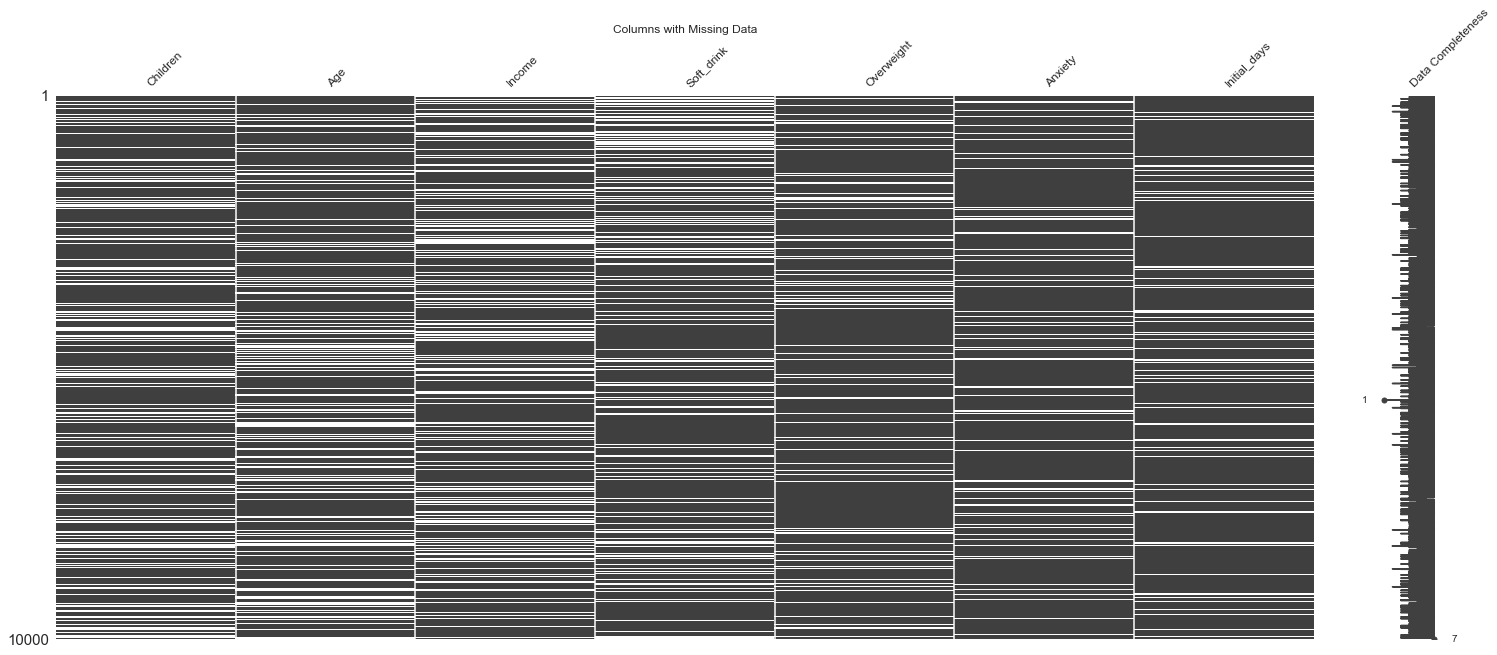

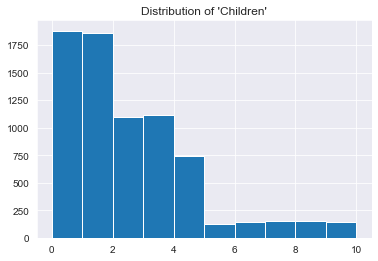

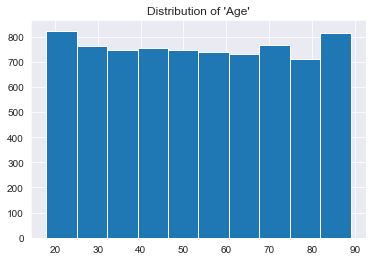

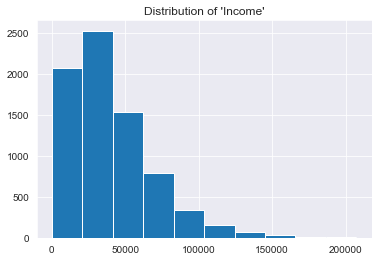

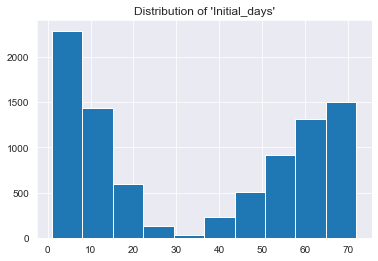

In [22]:
missing_data_columns = missing_data['Column']

msno.matrix(medical_data[missing_data_columns], fontsize = 12, labels = True)
plt.title('Columns with Missing Data')
plt.show()

#Need to filter out categorical columnas as those are a MODE Imputation. Need to check numerical columns for Normal or Left/Right Skew.
category_columns = pd.Series(list(convert_to_category.keys()))
numerical_nas = missing_data_columns[~missing_data_columns.isin(category_columns)]

for numerical_column in numerical_nas:
    df = medical_data[numerical_column]
    df.hist()
    plt.title(f"Distribution of '{numerical_column}'")
    plt.show()


#### Detecting Outliers

##### Description:

Here we will gather the columns that have a numerical data type of `int64` and `float64`. We'll loop through each column name and create and display a boxplot. Each boxplot will need to be visually checke to see if there are any data points out side of the boxplot whiskers, which indicates there are outliers.

Boxplots to be generated '13'


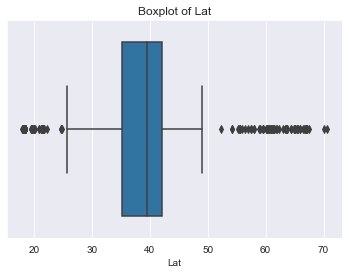

  Variable  Total_Outliers  Outlier_Min_Value  Outlier_Max_Value
0      Lat             150           17.96719           70.56099


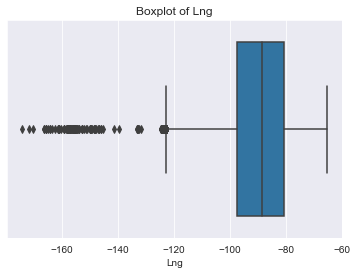

  Variable  Total_Outliers  Outlier_Min_Value  Outlier_Max_Value
0      Lng             237         -174.20969         -122.72547


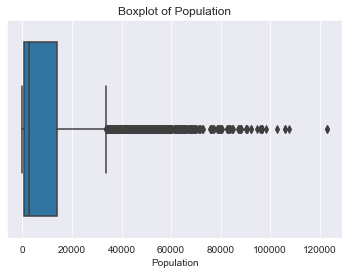

     Variable  Total_Outliers  Outlier_Min_Value  Outlier_Max_Value
0  Population             855              33894             122814


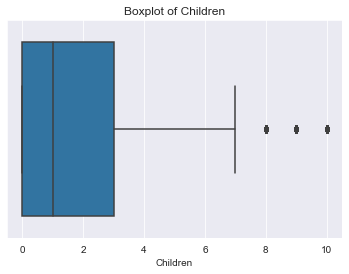

   Variable  Total_Outliers  Outlier_Min_Value  Outlier_Max_Value
0  Children             303                8.0               10.0


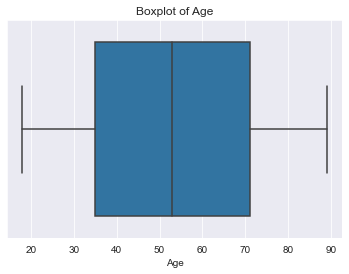

  Variable  Total_Outliers  Outlier_Min_Value  Outlier_Max_Value
0      Age               0                0.0                0.0


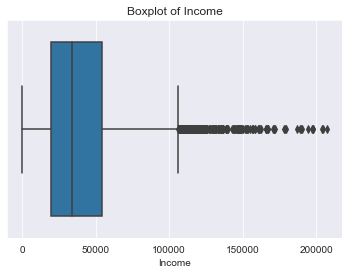

  Variable  Total_Outliers  Outlier_Min_Value  Outlier_Max_Value
0   Income             252          106220.51          207249.13


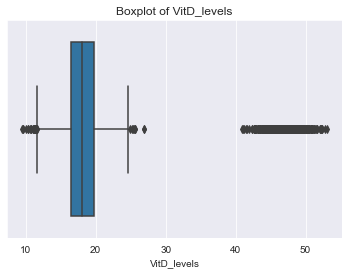

      Variable  Total_Outliers  Outlier_Min_Value  Outlier_Max_Value
0  VitD_levels             534           9.519012          53.019124


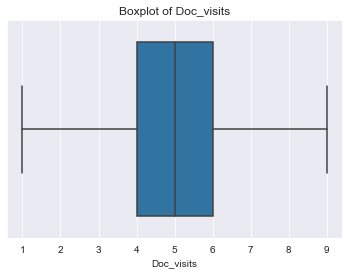

     Variable  Total_Outliers  Outlier_Min_Value  Outlier_Max_Value
0  Doc_visits               0                0.0                0.0


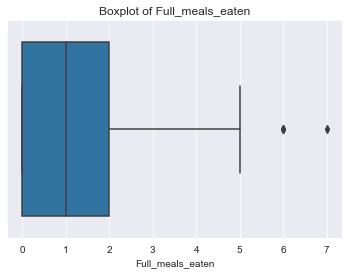

           Variable  Total_Outliers  Outlier_Min_Value  Outlier_Max_Value
0  Full_meals_eaten               8                  6                  7


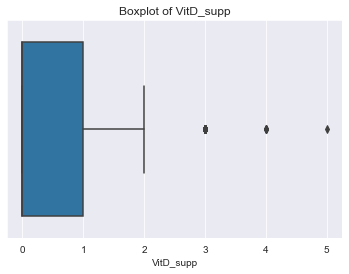

    Variable  Total_Outliers  Outlier_Min_Value  Outlier_Max_Value
0  VitD_supp              70                  3                  5


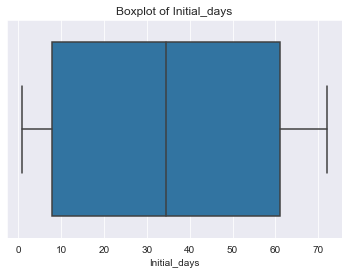

       Variable  Total_Outliers  Outlier_Min_Value  Outlier_Max_Value
0  Initial_days               0                0.0                0.0


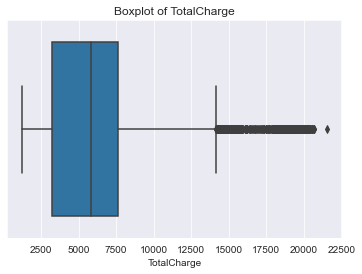

      Variable  Total_Outliers  Outlier_Min_Value  Outlier_Max_Value
0  TotalCharge             466        14159.65973        21524.22421


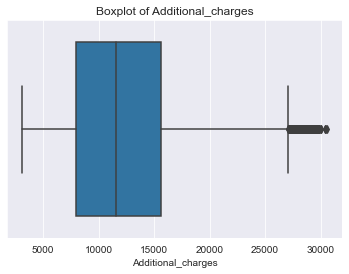

             Variable  Total_Outliers  Outlier_Min_Value  Outlier_Max_Value
0  Additional_charges             424        27088.14922        30566.07313


In [23]:
# Interquartile Range (IQR)
# Outliers are values falling outside the 25th and 75th percentile
# https://www.vedantu.com/maths/interquartile-range
def getOutliers_IQR(dataframe: pd.DataFrame, columnName: str):
    variableOfInterest = dataframe[columnName]

    quantile1 = variableOfInterest.quantile(0.25)
    quantile3 = variableOfInterest.quantile(0.75)

    interquartile_range = quantile3 - quantile1

    below_25_select = variableOfInterest < (quantile1 - 1.5 * interquartile_range)
    above_75_select = variableOfInterest > (quantile3 + 1.5 * interquartile_range)

    outliers = variableOfInterest[below_25_select | above_75_select]

    summary = {
        'Variable': [columnName],
        'Total_Outliers': [outliers.count()],
        'Outlier_Min_Value': [outliers.min()],
        'Outlier_Max_Value': [outliers.max()]
    }

    summary_dataframe = pd.DataFrame(summary)

    summary_dataframe.fillna(value=0, inplace=True)

    return summary_dataframe

# Get all numerical columns
numerical_columns = medical_data.select_dtypes(include=[np.int64, np.float64]).columns

numerical_quantitative = numerical_columns.get_indexer_for(['CaseOrder', 'Overweight', 'Anxiety'])
numerical_columns = numerical_columns.delete(numerical_quantitative)

print(f"Boxplots to be generated '{numerical_columns.size}'")

for column in numerical_columns:
    sb.boxplot(x = medical_data[column])
    plt.title(f"Boxplot of {column}")
    plt.show()
    print(getOutliers_IQR(medical_data, column))


#### Treatment for Duplicates

##### Description:

What defined a duplicate did not produce any entries. There are no treatments needed for duplicates for the `Medical Data Set`

#### Treatments for Missing Data

##### Description:
    The columns listed below with missing data we will chart their distribution to help choose with statistical central tendency value to use for imputation.

**Columns with missing data**
* Children - 2588 - Numerical
* Age -2414 - Numerical
* Income - 2464 - Numerical
* Soft_drink - 2467 - Categorical
* Overweight - 982 - Categorical (Numerical needing converting to Categorical Yes/No)
* Anxiety - 984 - Categorical (Numerical needing converting to Categorical Yes/No)
* Initial_days - 1056 - Numerical

<br>



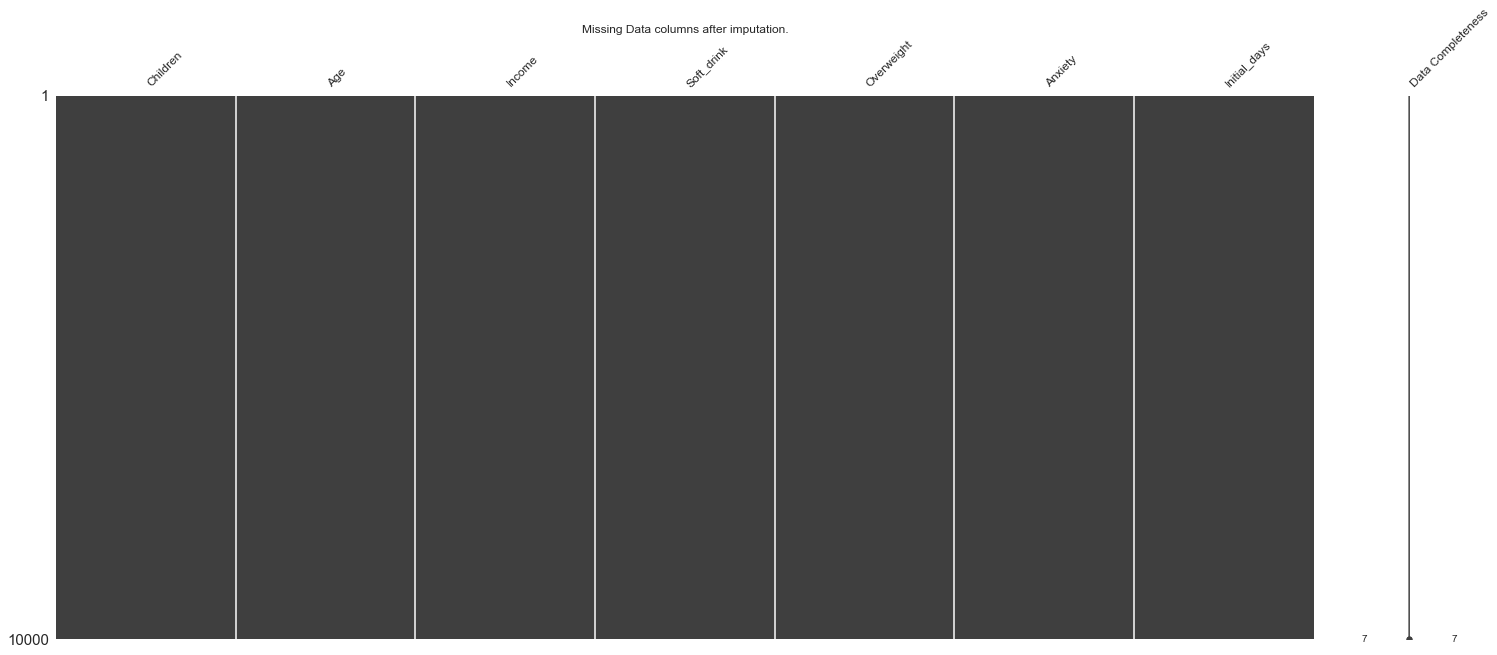

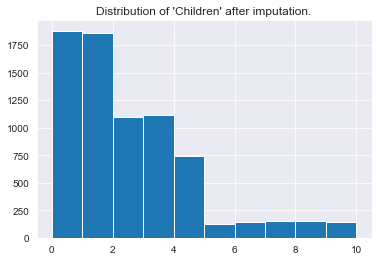

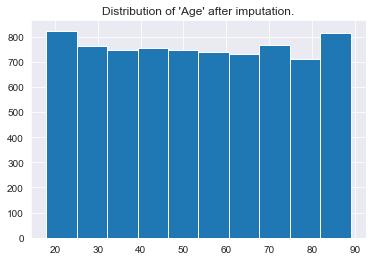

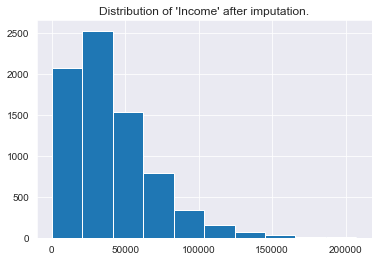

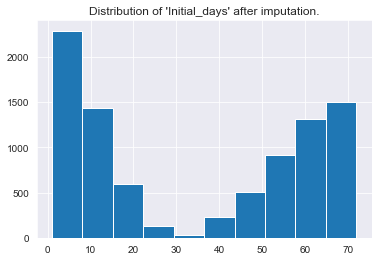

In [24]:
# ‘kde’ : Kernel Density Estimation plot
  
imputations = {
     'Children': int(medical_data['Children'].median()) #Right skewed
    ,'Age': int(medical_data['Age'].mode()) #U-Shaped [Bi-Modal]
    ,'Income': medical_data['Income'].median() #Right skewed
    ,'Soft_drink': medical_data['Soft_drink'].mode()[0] #Categorical
    ,'Overweight': int(medical_data['Overweight'].mode()[0]) #Categorical
    ,'Anxiety': int(medical_data['Anxiety'].mode()[0]) #Categorical
    ,'Initial_days': medical_data['Initial_days'].mode()[0] #U-Shaped Bi-Modal
}

imputated_medical_data = medical_data.fillna(imputations)

#Visualization check
msno.matrix(imputated_medical_data[missing_data_columns], fontsize=12, labels=True)
plt.title('Missing Data columns after imputation.')
plt.show()

for numerical_column in numerical_nas:
    numericals = medical_data[numerical_column]
    numericals.hist()
    plt.title(f"Distribution of '{numerical_column}' after imputation.")
    plt.show()

convert_to_int64 = {
    'Age': np.int64,
    'Children': np.int64
}

imputated_medical_data = imputated_medical_data.astype(convert_to_int64)

#### Treatment for Outliers

##### Description:

The treatment plan for the outliers is in the `Medical Dataset` is Retain with noting of their existence. The values that have presented themselves as outliers are valid values within the context of the given variables. There is one variable (column) `VitD_levels` that have a weird mix of outliers at first glance but are valid. To help with the understanding of the `VitD_levels` a new variable(column) will be calculated. It will be the human readable version of the variables that falls into 3 levels/bins. Low, Adequate, and High are categorical values that correspond to Vitmin D Level ranges.

**Vitamin D Level Ranges:**
* Low -> 12 or below
* Adequate -> 20 or above
* High -> 50 or above 

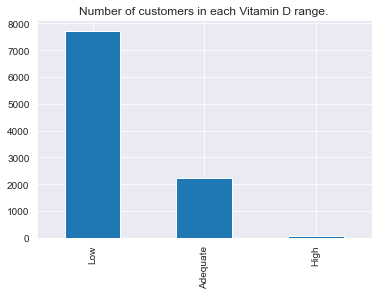

In [25]:
# https://www.medicalnewstoday.com/articles/normal-vitamin-d-levels#function
vitamin_d_bins = [0, 20, 50, np.inf]
vitamin_d_categories = ['Low', 'Adequate', 'High']

vitd_levels_group = pd.cut(imputated_medical_data['VitD_levels'], bins=vitamin_d_bins, labels=vitamin_d_categories)

vitd_level_index = imputated_medical_data.columns.get_loc('VitD_levels')
imputated_medical_data.insert((vitd_level_index + 1), 'VitD_levels_level', vitd_levels_group)

chart_data = imputated_medical_data['VitD_levels_level'].value_counts()
chart_data.plot.bar(x='Vitamin D Range', y='Customer Count')
plt.title('Number of customers in each Vitamin D range.')
plt.show()


#### Detecting 0/1's that need Re-Expression

In [26]:
noyes_as_bits = [0, 1]
columns_to_reexpress = []

numerical_columns = medical_data.select_dtypes(include=[np.int64, np.float64]).columns

for column in numerical_columns:
    if imputated_medical_data[column].isin(noyes_as_bits).all():
        columns_to_reexpress.append(column)

print(f"Re-Expression needed for {columns_to_reexpress}")


Re-Expression needed for ['Overweight', 'Anxiety']


#### Treatment for Re-Expression


In [27]:
# Detected values of pure 0/1's should be Re-Expressed into Yes/No.
for column in columns_to_reexpress:
    imputated_medical_data[column] = imputated_medical_data[column].map({1: 'Yes', 0: 'No'})

imputated_medical_data[columns_to_reexpress].head()

,Overweight,Anxiety
0,No,Yes
1,Yes,No
2,Yes,No
3,No,No
4,No,No


#### Exporting the finalized cleaned-up data to csv file

##### Description:

* [to_csv documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html)

In [28]:
imputated_medical_data.to_csv(r'./medical_cleaned_data.csv')

#### Principle Component Analysis (PCA)

* Must be run on cleaned data
* Must only include numerical data of the same scale
* Group each component based on similarity

In [29]:
medical_data_clean = imputated_medical_data

#Use Discrete and Continious data only
pca_columns = ['Lat', 'Lng', 'Population', 'Age', 'Children', 'Income', 'VitD_levels', 'Full_meals_eaten', 'VitD_supp', 'Initial_days', 'TotalCharge', 'Additional_charges']

pca_df = medical_data_clean[pca_columns]

#normalization (AH HA MOMENT: This makes sense as to why outliers can be damaging to analysis)
#Wildly skewed outliers will pull the math in uncertain directions
pca_normalized = (pca_df - pca_df.mean()) / pca_df.std()

pca = PCA(n_components=pca_normalized.shape[1])
print(pca) #Should be PCA(n_component=12)

pca.fit(pca_normalized)


component_columns = []
for i in range(1, len(pca_columns) + 1):
    component_columns.append(f"PC{i}")

pca_result = pd.DataFrame(pca.transform(pca_normalized), columns=component_columns)
#pca_result

pca_loadings = pd.DataFrame(pca.components_.T, columns=component_columns, index=pca_normalized.columns)
pca_loadings

PCA(n_components=12)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
Lat,-0.019103,0.000525,-0.715862,0.120027,-0.058314,-0.010630,-0.027906,-0.048367,-0.055179,0.680481,-0.005815,0.002466
Lng,-0.003798,0.023395,0.271529,-0.624134,-0.466557,0.140263,0.368730,0.059622,0.101534,0.385566,0.018183,0.000446
Population,0.023410,-0.033002,0.630240,0.296158,0.262502,-0.118561,-0.210986,-0.070150,-0.018597,0.616820,-0.015421,-0.000535
Age,0.059505,0.703362,0.012628,0.013586,-0.023574,-0.019722,-0.009883,0.005858,-0.035190,0.000766,-0.706350,0.012336
Children,0.002956,0.010679,0.008274,0.315039,0.227809,-0.000047,0.836938,-0.353520,0.151731,-0.005883,-0.012695,0.001379
Income,-0.006979,0.000473,0.044378,0.178982,0.140765,0.759914,0.149866,0.437308,-0.391148,0.044356,-0.000727,0.000213
VitD_levels,0.560392,-0.035356,-0.044569,-0.256832,0.235910,0.265748,-0.130520,-0.394352,-0.022006,0.005251,-0.019203,-0.563078
Full_meals_eaten,-0.007066,0.032327,-0.102859,-0.274319,0.580715,-0.011781,0.035653,0.466558,0.592556,0.072016,-0.020555,0.005136
VitD_supp,0.032537,0.004845,0.030640,0.372691,-0.395156,0.437464,-0.203281,-0.111611,0.676082,-0.021203,-0.015535,-0.000236
Initial_days,0.423004,-0.063777,0.020162,0.308119,-0.297691,-0.354950,0.189276,0.535924,0.009936,-0.004122,-0.007930,-0.428752


#### Selecting PCs

##### Kaiser Rule (Eigenvalues):
Must calculate covariance and vectors; then define eigenvalues before performing scree plot

[1.9161332421076744, 1.5316414568998453, 1.2262967116649421, 1.0413133281667917, 1.023992957932782, 1.009219557667683, 0.9960241300668137, 0.9836200705772584, 0.9738927452781899, 0.7474696435194794, 0.4663701639771893, 0.0828259921412876]


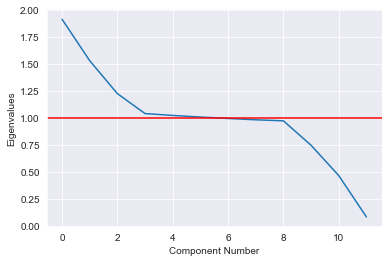

In [30]:
covariant_matrix = np.dot(pca_normalized.T, pca_normalized) / pca_df.shape[0]
eigenvalues = [np.dot(eigenvector.T, np.dot(covariant_matrix, eigenvector)) for eigenvector in pca.components_]

print(eigenvalues)

plt.plot(eigenvalues)
plt.xlabel('Component Number')
plt.ylabel('Eigenvalues')
plt.axhline(y=1, color='red')
plt.show()
